In [2]:
def Validation(n_fold,X,Y):
    list_train_fold = []
    list_val_fold = []
    list_train = []
    Number = X.shape[0]//n_fold
    for i in range(X.shape[0]):
        list_train.append(i)
    
    for i in range(n_fold)[::-1]:
        list_val = []
        if i==n_fold-1:
            for j in range(Number*i,X.shape[0]):
                list_val.append(j)
            list_train_fold.append(np.setdiff1d(list_train,list_val))
            list_val_fold.append(list_val)
            
        
        if i != n_fold-1: 
            for j in range(Number*i,Number*(i+1)):
                list_val.append(j)
            list_train_fold.append(np.setdiff1d(list_train,list_val))
            list_val_fold.append(list_val)
        
    return list_train_fold, list_val_fold
            





In [3]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils
# modified
import tensorflow.compat.v1 as tf
import numpy as np
import time
import pandas as pd
%matplotlib inline
import tensorflow as tf
tf.__version__




'1.15.0'

# Dataset, Graph 구성

50138


/home/bmllab/bml_ksh/Methods/lib/coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])
/home/bmllab/bml_ksh/Methods/lib/coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])


Layer 0: M_0 = |V| = 704 nodes (41 added),|E| = 25069 edges
Layer 1: M_1 = |V| = 352 nodes (13 added),|E| = 20061 edges
Layer 2: M_2 = |V| = 176 nodes (5 added),|E| = 10319 edges
Layer 3: M_3 = |V| = 88 nodes (2 added),|E| = 3552 edges
Layer 4: M_4 = |V| = 44 nodes (1 added),|E| = 903 edges
Layer 5: M_5 = |V| = 22 nodes (0 added),|E| = 231 edges
Layer 6: M_6 = |V| = 11 nodes (0 added),|E| = 55 edges


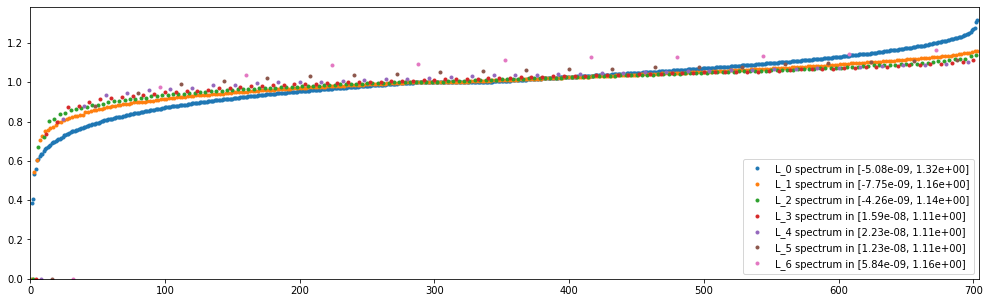

In [4]:
from scipy.sparse import coo_matrix
data = pd.read_csv("Data/L1000/groupPPI.csv")
data.drop(['Unnamed: 0'], axis='columns', inplace=True)
data_IC50 = pd.read_csv("Data/Table_S6_GDSC_Drug_response_IC50.csv")
data_IC50.drop(['Unnamed: 0'], axis='columns', inplace=True)
data2 = pd.read_csv("Data/L1000/groupEXP.csv")
data2.drop(['Unnamed: 0'], axis='columns', inplace=True)
data2=np.array(data2)

df = np.array(data)
A = coo_matrix(df,dtype=np.float32)
print(A.nnz)
graphs, perm = coarsening.coarsen(A, levels=6, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)


# Data 설정, Parameter 설정, 학습 및 저장

In [25]:
from scipy.sparse import coo_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats

n_fold = 3
X_train, X_test, Y_train, Y_test = train_test_split(data2, data_IC50,  
                                                              test_size=0.25, shuffle=True, random_state=20)# 입력 형태 받아오기



for cv in range(n_fold): #cv 만큼 반복
    Y_pred = np.zeros([Y_test.shape[0], Y_test.shape[1]]) # 마지막에 npz로 저장하기 위한 틀
    Y_test = np.zeros([Y_test.shape[0], Y_test.shape[1]]) # //
    j = 0
    for i in range(201): # 약물 갯수  data_IC50.shape[1] (734 * 201)
        ## MinMax Scaling
        data1 = data_IC50.iloc[:,i]  
        data1 = np.array(data1)
        data_minmax = data1[~np.isnan(data1)]
        min = data_minmax.min()
        max = data_minmax.max()
        data1 = (data1 - min) / (max - min)
        
        
        # 각 약물에 대해 Train, Test 3:1로 분리
        train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(data2, data1, 
                                                              test_size=0.25, shuffle=True, random_state=20)
        # Nan값이 있는 부분은 Train Set에서 제거
        train_data = np.array(train_data_split[~np.isnan(train_labels_split)]).astype(np.float32)
        
        #  3Fold 구성
        list_train, list_val = Validation(n_fold,train_data,train_labels_split)
        
        train_data_V = train_data[list_train[cv]]
        val_data = train_data[list_val[cv]]
        test_data = np.array(test_data_split[:]).astype(np.float32)
        
        # Nan값이 있는 부분은 Train Set에서 제거
        train_labels = np.array(train_labels_split[~np.isnan(train_labels_split)]).astype(np.float32)
        train_labels_V = train_labels
        val_labels = train_labels[list_val[cv]]
        test_labels = np.array(test_labels_split[:]).astype(np.float32)
        
        # 그래프와 Gene 위치 및 갯수 조정
        train_data_V = coarsening.perm_data(train_data_V, perm)
        val_data = coarsening.perm_data(val_data, perm)
        test_data = coarsening.perm_data(test_data, perm)
        
        # 파라미터 설정
        common = {}
        common['num_epochs']     = 40
        common['batch_size']     = 4
        common['decay_steps']    = train_data.shape[0] / common['batch_size']
        common['eval_frequency'] = 10 * common['num_epochs']
        common['brelu']          = 'b1relu'
        common['pool']           = 'mpool1'

        common['regularization'] = 0
        common['dropout']        = 1
        common['learning_rate']  = 0.02
        common['decay_rate']     = 0.95
        common['momentum']       = 0.9
        common['F']              = [20, 10]
        common['K']              = [40,20]
        common['p']              = [4,4]
        common['M']              = [128,1]

        if True:
            name = 'cgconv_softmax'
            params = common.copy()
            
        model = models.cgcnn(L, **params)
        loss, t_step = model.fit(train_data_V, train_labels_V, val_data, val_labels)

        Y_pred[:, j] = model.predict(test_data)
        Y_test[:, j] = test_labels
        j = j+1
    # 저장    
    np.savez(('parameter.cv_{}'.format(cv)), Y_true=Y_test, Y_pred=Y_pred)
    

NN architecture
  input: M_0 = 704
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 704 * 20 / 4 = 3520
    weights: F_0 * F_1 * K_1 = 1 * 20 * 40 = 800
    biases: F_1 = 20
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 176 * 10 / 4 = 440
    weights: F_1 * F_2 * K_2 = 20 * 10 * 20 = 4000
    biases: F_2 = 10
  layer 3: fc1
    representation: M_3 = 128
    weights: M_2 * M_3 = 440 * 128 = 56320
    biases: M_3 = 128
  layer 4: logits (softmax)
    representation: M_4 = 1
    weights: M_3 * M_4 = 128 * 1 = 128
    biases: M_4 = 1




KeyboardInterrupt: 

# RMSE, PCC, SCC

In [27]:
from scipy import stats
from sklearn.metrics import mean_squared_error
RMSE = []
PCC = []
SCC = []

for i in range(1): # 약물 갯수
    y_test = Y_test[:, i]
    y_pred = Y_pred[:, i]
    y_pred = y_pred[~np.isnan(y_test)]
    y_test = y_test[~np.isnan(y_test)]

    RMSE.append(mean_squared_error(y_test,y_pred))
    PCC.append(stats.pearsonr(y_test,y_pred)[0])
    SCC.append(stats.spearmanr(y_test,y_pred)[0])
print("RMSE :",RMSE)
print("PCC :",PCC)
print("SCC :",SCC)

RMSE : [0.0]
PCC : [nan]
SCC : [nan]


/home/bmlserver/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/bmlserver/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
